## Importing the Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Importing the dataset

In [3]:
df = pd.read_csv('D:\Become Assessment\SatisfactionSurvey.csv')
df.head(10)

,CustomerID,Age,Subscription Months,Satisfaction Score (1-10),Feedback
0,1,22.0,1.0,8.0,Fresh ingredients and well-balanced meals—high...
1,2,23.0,24.0,7.0,"Good quality, needs more variety."
2,3,22.0,NaN,8.0,"Great meal plans, and customer service is fant..."
3,4,NaN,16.0,NaN,"Great meal plans, and customer service is fant..."
4,5,31.0,9.0,7.0,"Some meals were great, others were average."
5,6,21.0,1.0,7.0,I wish they had more flexible delivery times.
6,7,30.0,1.0,10.0,The subscription saves me so much time!
7,8,21.0,15.0,9.0,Loved the variety and convenience of the meals!
8,9,21.0,4.0,NaN,I wish they had more flexible delivery times.
9,10,29.0,2.0,8.0,"Great meal plans, and customer service is fant..."


## Cleaning and Filling the null values

In [4]:
df = df.set_index('CustomerID')

### Capping the Age values

In [5]:
df['Age'] = df['Age'].apply(lambda age : 18 if age < 18 else (90 if age > 90 else age))

In [6]:
df

,Age,Subscription Months,Satisfaction Score (1-10),Feedback
CustomerID,,,,
1,22.0,1.0,8.0,Fresh ingredients and well-balanced meals—high...
2,23.0,24.0,7.0,"Good quality, needs more variety."
3,22.0,NaN,8.0,"Great meal plans, and customer service is fant..."
4,NaN,16.0,NaN,"Great meal plans, and customer service is fant..."
5,31.0,9.0,7.0,"Some meals were great, others were average."
...,...,...,...,...
9996,67.0,17.0,10.0,Loved the variety and convenience of the meals!
9997,73.0,8.0,3.0,The ingredients didn’t seem fresh.
9998,67.0,10.0,6.0,"Some meals were great, others were average."


In [7]:
df['Subscription Months'].mean()

7.062869245346115

### Dealing with Null Values

In [8]:
df['Age'].fillna(value=df['Age'].median(),inplace=True)
df['Subscription Months'].fillna(value=df['Subscription Months'].median(),inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        10000 non-null  float64
 1   Subscription Months        10000 non-null  float64
 2   Satisfaction Score (1-10)  8448 non-null   float64
 3   Feedback                   10000 non-null  object 
dtypes: float64(3), object(1)
memory usage: 390.6+ KB


### Filling the null values in the Satisfaction Score column

 The null values in the Satisfaction Score column can't be filled with either mean or median values. This is because the Satisfaction Score column is directly related to the feedback column. Using Mean or Median would give us an incorrect value of the Satisfaction score which sometimes won't match the feedback given by the user. If the feedback was limited to a particular set of options we can easily determine the score for each feedback based on the non null values of the feedback and satisfaction scores, but since the feedback is of free text, we'll have to perform a sentiment analysis to determine whether the feedback is positive, negative or neutral. Based on this classification, we can then assign a value for the satisfaction score.

Here we'll be using the Hugging Face’s transformers library and the "cardiffnlp/twitter-roberta-base-sentiment" model, to classify the feedback into Positive, Neutral, or Negative.

In [10]:
from transformers import pipeline
import torch

# Loading model 
sentiment_pipeline = pipeline("sentiment-analysis", 
                              model="cardiffnlp/twitter-roberta-base-sentiment", 
                              device=0 if torch.cuda.is_available() else -1)            # Setting to utilize the GPU and not the CPU

# Define a function to get sentiment labels
def get_sentiment(text):
    result = sentiment_pipeline(str(text))[0]  # Process text
    label = result["label"]  # Extract label
    return label  # Returns either "positive", "neutral", or "negative"


df["Sentiment"] = df["Feedback"].apply(get_sentiment)
print(df[["Feedback", "Sentiment"]].head())


Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


                                                     Feedback Sentiment
CustomerID                                                             
1           Fresh ingredients and well-balanced meals—high...   LABEL_2
2                           Good quality, needs more variety.   LABEL_2
3           Great meal plans, and customer service is fant...   LABEL_2
4           Great meal plans, and customer service is fant...   LABEL_2
5                 Some meals were great, others were average.   LABEL_1


In [11]:
df['Sentiment'].replace(to_replace=['LABEL_0','LABEL_1','LABEL_2'],value=['Negative','Neutral','Positive'],inplace=True)

In [12]:
df

,Age,Subscription Months,Satisfaction Score (1-10),Feedback,Sentiment
CustomerID,,,,,
1,22.0,1.0,8.0,Fresh ingredients and well-balanced meals—high...,Positive
2,23.0,24.0,7.0,"Good quality, needs more variety.",Positive
3,22.0,5.0,8.0,"Great meal plans, and customer service is fant...",Positive
4,34.0,16.0,NaN,"Great meal plans, and customer service is fant...",Positive
5,31.0,9.0,7.0,"Some meals were great, others were average.",Neutral
...,...,...,...,...,...
9996,67.0,17.0,10.0,Loved the variety and convenience of the meals!,Positive
9997,73.0,8.0,3.0,The ingredients didn’t seem fresh.,Negative
9998,67.0,10.0,6.0,"Some meals were great, others were average.",Neutral


Now we can fill the null values of the Satisfaction Score column based on the values of the Sentiment Column

In [13]:
def fill_satisfaction(row):
    if pd.isna(row["Satisfaction Score (1-10)"]): 
        if row["Sentiment"] == "Positive":
            return np.random.randint(7, 10)  
        elif row["Sentiment"] == "Negative":
            return np.random.randint(1, 4)  
        else:
            return np.random.randint(4, 7)  
    return row["Satisfaction Score (1-10)"]  

df["Satisfaction Score (1-10)"] = df.apply(fill_satisfaction, axis=1)


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        10000 non-null  float64
 1   Subscription Months        10000 non-null  float64
 2   Satisfaction Score (1-10)  10000 non-null  float64
 3   Feedback                   10000 non-null  object 
 4   Sentiment                  10000 non-null  object 
dtypes: float64(3), object(2)
memory usage: 468.8+ KB


## Analysis

### Age Distribution

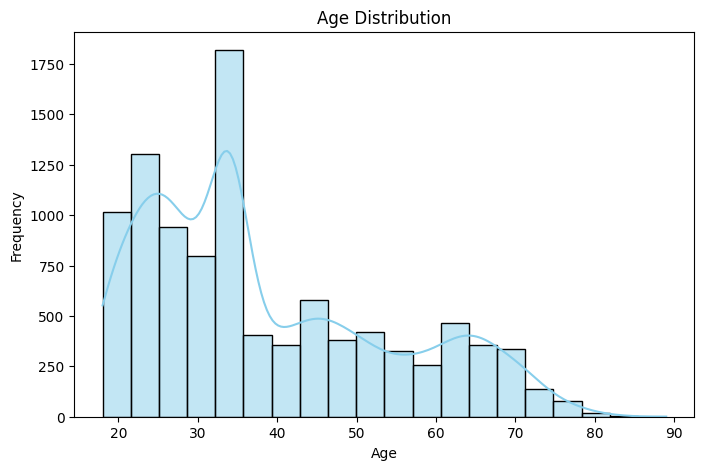

In [15]:
plt.figure(figsize=(8, 5))  # Set figure size
sns.histplot(df["Age"], bins=20, kde=True, color="skyblue")

# Labels and title
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Age Distribution")

plt.show()


### Who are the most satisfied?

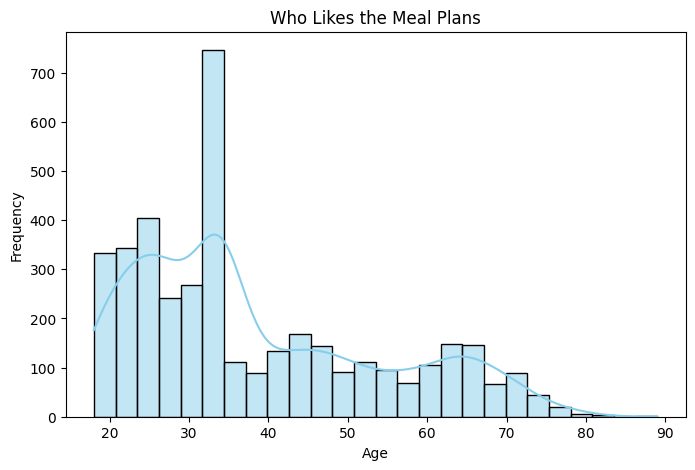

In [16]:
plt.figure(figsize=(8,5))

sns.histplot(df[df['Satisfaction Score (1-10)'] > 7]['Age'],kde=True,color='skyblue')

plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Who Likes the Meal Plans")

plt.show()



### Does more satisfaction mean more subscription time?

In [17]:
new_df = df.groupby(by='Satisfaction Score (1-10)').mean('Subscription Months')[['Subscription Months']]

In [18]:
new_df

,Subscription Months
Satisfaction Score (1-10),
1.0,6.607595
2.0,7.162602
3.0,6.887789
4.0,6.997195
5.0,6.768974
6.0,6.994406
7.0,6.802901
8.0,6.750419
9.0,6.797045


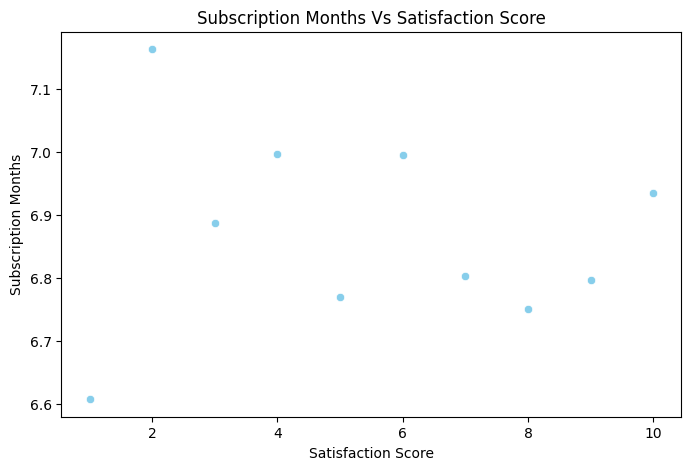

In [19]:
plt.figure(figsize=(8,5))

sns.scatterplot(x=new_df.index,y=new_df['Subscription Months'],color = 'skyblue')

plt.ylabel("Subscription Months")
plt.xlabel("Satisfaction Score")
plt.title("Subscription Months Vs Satisfaction Score")

plt.show()


### Feedbacks

In [20]:
feedbacks = df['Sentiment'].value_counts()
feedbacks

Sentiment
Positive    5942
Neutral     2990
Negative    1068
Name: count, dtype: int64

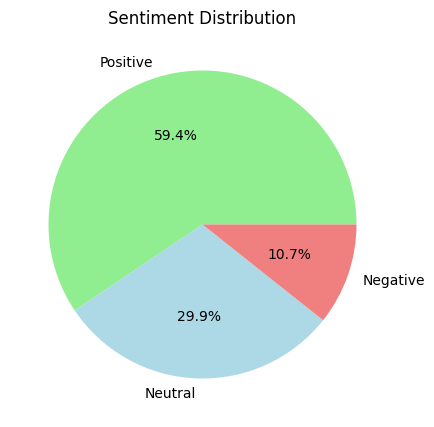

In [21]:
plt.figure(figsize=(8,5))

plt.pie(feedbacks,labels=feedbacks.index,autopct='%1.1f%%',colors=["lightgreen", "lightblue", "lightcoral"])

plt.title("Sentiment Distribution")
plt.show()

### What do the users say?

In [22]:
import yake

# Set up YAKE extractor
yake_extractor = yake.KeywordExtractor(lan="en", n=2, top=5)

# Extract keywords from each feedback
df["YAKE Keywords"] = df["Feedback"].dropna().apply(lambda x: yake_extractor.extract_keywords(x))

print(df[["Feedback", "YAKE Keywords"]].head())


                                                     Feedback  \
CustomerID                                                      
1           Fresh ingredients and well-balanced meals—high...   
2                           Good quality, needs more variety.   
3           Great meal plans, and customer service is fant...   
4           Great meal plans, and customer service is fant...   
5                 Some meals were great, others were average.   

                                                YAKE Keywords  
CustomerID                                                     
1           [(highly recommend, 0.02570861714399338), (Fre...  
2           [(Good quality, 0.02570861714399338), (Good, 0...  
3           [(Great meal, 0.04940384002065631), (meal plan...  
4           [(Great meal, 0.04940384002065631), (meal plan...  
5           [(great, 0.09568045026443411), (average, 0.095...  


In [23]:
df['YAKE Keywords']

CustomerID
1        [(highly recommend, 0.02570861714399338), (Fre...
2        [(Good quality, 0.02570861714399338), (Good, 0...
3        [(Great meal, 0.04940384002065631), (meal plan...
4        [(Great meal, 0.04940384002065631), (meal plan...
5        [(great, 0.09568045026443411), (average, 0.095...
                               ...                        
9996     [(Loved, 0.09568045026443411), (meals, 0.09568...
9997     [(fresh, 0.15831692877998726), (ingredients, 0...
9998     [(great, 0.09568045026443411), (average, 0.095...
9999     [(Great meal, 0.04940384002065631), (meal plan...
10000    [(highly recommend, 0.02570861714399338), (Fre...
Name: YAKE Keywords, Length: 10000, dtype: object

In [24]:
keywords = []
for tup in df['YAKE Keywords']:
    keyword = tup[1][0]
    keywords.append(keyword)

In [25]:
keywordsdf = pd.DataFrame(keywords)
keywordsCountdf = pd.DataFrame(keywordsdf.value_counts())

In [26]:
keywordsCountdf

,count
0,
Good,1017
average,1000
flexible delivery,1000
outstanding,990
service,925
Fresh ingredients,816
tasty,800
meals,798
time,797


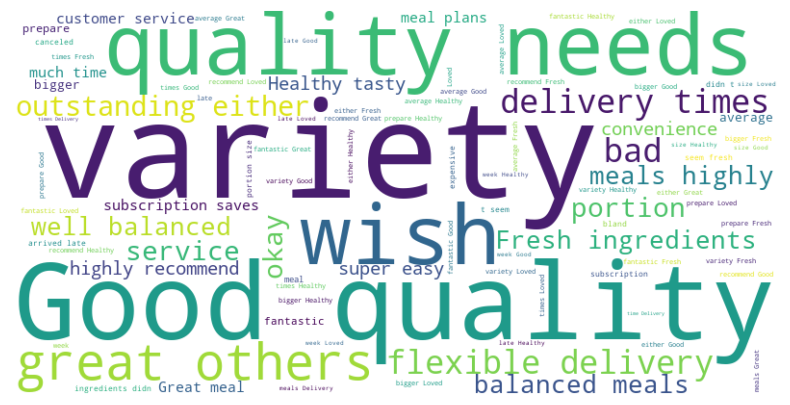

In [28]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all feedback into one text
feedback_text = " ".join(df["Feedback"].dropna())

# Generate word cloud
wordcloud = WordCloud(
    width=800, height=400, background_color="white", colormap="viridis", max_words=100
).generate(feedback_text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # Hide axes
plt.show()
